# Analyzing the MSTIS simulation

Included in this notebook:

* Opening files for analysis
* Rates, fluxes, total crossing probabilities, and condition transition probabilities
* Per-ensemble properties such as path length distributions and interface crossing probabilities
* Move scheme analysis
* Replica exchange analysis
* Replica move history tree visualization
* Replaying the simulation
* MORE TO COME! Like free energy projections, path density plots, and more

In [1]:
import logging
reload(logging)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info('Info logging activated')
init_log = logging.getLogger('openpathsampling.initialization')
init_log.setLevel(logging.CRITICAL)

INFO:root:Info logging activated


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

The optimum way to use storage depends on whether you're doing production or analysis. For analysis, you should open the file as an `AnalysisStorage` object. This makes the analysis much faster.

In [3]:
%%time
storage = paths.AnalysisStorage("mstis.nc")

INFO:openpathsampling.netcdfplus.netcdfplus:Open existing netCDF file 'mstis.nc' for reading - reading from existing file
INFO:openpathsampling.storage.storage:Cached all CVs in 269 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `cvs` [3] in 16 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `samples` [655] in 1459 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `samplesets` [501] in 105 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `volumes` [44] in 0 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `ensembles` [155] in 0 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `pathmovers` [89] in 303 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `pathmovechanges` [2367] in 865 ms
INFO:openpathsampling.storage.storage:Cache all objects of store `steps` [501] in 193 ms


CPU times: user 3.78 s, sys: 318 ms, total: 4.1 s
Wall time: 4.21 s


In [4]:
mstis = storage.networks.load(0)

In [5]:
for store in storage.objects.values():
    print store.name, len(store.index), len(store), store.__class__.__name__

schemes 1 1 NamedObjectStore
[NamedObjectStore] 23 23 NamedObjectStore
snapshots 0 46928 SnapshotWrapperStore
tag 0 0 ImmutableDictStore
transitions 3 3 NamedObjectStore
networks 1 1 NamedObjectStore
ensembles 155 155 NamedObjectStore
engines 1 1 NamedObjectStore
topologies 1 1 NamedObjectStore
cv2 23464 23464 SnapshotValueStore
pathmovers 89 89 NamedObjectStore
cv0 23464 23464 SnapshotValueStore
cv1 23464 23464 SnapshotValueStore
details 0 2834 ObjectStore
samples 655 655 SampleStore
trajectories 422 422 TrajectoryStore
snapshot0 23464 23464 FeatureSnapshotStore
pathmovechanges 2367 2367 PathMoveChangeStore
shootingpointselectors 8 8 NamedObjectStore
pathsimulators 1 1 NamedObjectStore
cvs 6 3 CVStore
steps 501 501 MCStepStore
volumes 44 44 NamedObjectStore
samplesets 501 501 SampleSetStore


## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [6]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
mstis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }

In [7]:
cv = storage.cvs[0]

In [8]:
storage.trajectories[200]

Trajectory[86]

In [9]:
len(storage.snapshots.index)

1

In [10]:
len(storage.snapshot0)

23464

In [11]:
storage.trajectories.cache_all()

In [12]:
%%time
cv(storage.trajectories[378])

CPU times: user 862 µs, sys: 223 µs, total: 1.08 ms
Wall time: 940 µs


[0.035409947435413258,
 0.040936626463328629,
 0.04583503174198178,
 0.050542406421371311,
 0.055260014346999675,
 0.058891987760074649,
 0.061880367669647995,
 0.064906980556625804,
 0.068009038169989822,
 0.070440946841479501,
 0.072518592200546017,
 0.075045350090604757,
 0.077787059824854232,
 0.080383316923104076,
 0.0836338097858631,
 0.086980699370684533,
 0.088961632988631578,
 0.090714858437796586,
 0.092893026950065405,
 0.094518931566213382,
 0.094482871216013287,
 0.092883549234876739,
 0.090107313072582684,
 0.086182451501120028,
 0.080752599658197255,
 0.073872238506496934,
 0.066572945582414889,
 0.060228549303843693,
 0.054359069308592467,
 0.04877656842079503,
 0.043545065941067662,
 0.037910908824341227]

In [13]:
sum(map(len, storage.trajectories))

41996

In [14]:
q = storage.snapshots.all()

In [15]:
len(q)

46928

In [16]:
for cv in storage.cvs:
    print cv.diskcache_enabled

True
True
True


In [17]:
print cv._store_dict.value_store.cache._chunkdict.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [18]:
print cv._store_dict._get(q.as_proxies()[10])

0.683997142527


In [19]:
cv._store_dict.value_store.get(q.as_proxies()[10])

0.68399714252719679

In [20]:
ll = []

In [21]:
%%time
for snap in q.as_proxies():
#     print snap.__uuid__
    ll.append(cv._store_dict.value_store[snap])

CPU times: user 355 ms, sys: 86.4 ms, total: 442 ms
Wall time: 382 ms


In [22]:
%%time
cv[q.as_proxies()[0:10000]]

CPU times: user 206 ms, sys: 63.8 ms, total: 270 ms
Wall time: 225 ms


[1.0600000000000001,
 1.0600000000000001,
 0.70470559317863968,
 0.70470559317863968,
 0.69190836766833919,
 0.69190836766833919,
 0.68498775491914177,
 0.68498775491914177,
 0.68205708772317231,
 0.68205708772317231,
 0.68399714252719679,
 0.68399714252719679,
 0.68923868775707231,
 0.68923868775707231,
 0.69404894683625795,
 0.69404894683625795,
 0.69673967676921034,
 0.69673967676921034,
 0.70126905990729071,
 0.70126905990729071,
 0.70791130382010659,
 0.70791130382010659,
 0.71180735669596895,
 0.71180735669596895,
 0.71189200716937162,
 0.71189200716937162,
 0.70802013174697531,
 0.70802013174697531,
 0.70085224890798947,
 0.70085224890798947,
 0.69275601460260006,
 0.69275601460260006,
 0.68619375783575964,
 0.68619375783575964,
 0.68138332569998572,
 0.68138332569998572,
 0.67655191588343888,
 0.67655191588343888,
 0.66928650282550339,
 0.66928650282550339,
 0.65971319236290438,
 0.65971319236290438,
 0.64957478415956649,
 0.64957478415956649,
 0.64052245708544442,
 0.640522457

In [23]:
%%time
_ = cv[q]

CPU times: user 916 ms, sys: 77.6 ms, total: 994 ms
Wall time: 947 ms


In [25]:
%%timeit
_ = cv[storage.snapshots.all()]

1 loop, best of 3: 226 ms per loop


In [26]:
%%timeit
_ = cv(storage.snapshots.all())

1 loop, best of 3: 220 ms per loop


In [27]:
len(storage.snapshots.cache)

1

In [28]:
%%time
mstis.rate_matrix(storage.steps, force=True)

INFO:openpathsampling.analysis.wham:iterations=22diff=5.98309179981e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -0.24096596672419082, -0.558171271952684]
INFO:openpathsampling.analysis.wham:iterations=71diff=8.18632939227e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -0.5679780763969339, -1.3304576422914243]
INFO:openpathsampling.analysis.wham:iterations=1318diff=9.87350201609e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -1.0148590872723395, -1.0337454689720553]
INFO:openpathsampling.analysis.tis_analysis:Rate for B -> C
INFO:openpathsampling.analysis.tis_analysis:outer ensemble: I'face 2 <openpathsampling.ensemble.TISEnsemble object at 0x123829850>
INFO:openpathsampling.analysis.tis_analysis:outer lambda: 0.2
INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:RATE = 0.0
INFO:openpathsampling.analysis.tis_analysis:flux * outer_tcp * ctp = 0.00895255147717 * 0.0325349300378 * 0.0
INFO:openpathsampli

CPU times: user 2.9 s, sys: 67.2 ms, total: 2.97 s
Wall time: 2.96 s


,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.00339823,0.000292321
"{x|opB(x) in [0.0, 0.04]}",0.000283713,NaN,0
"{x|opC(x) in [0.0, 0.04]}",0,0,NaN


In [29]:
%%time
for t in storage.trajectories:
    q = cv(t)

CPU times: user 600 ms, sys: 22 ms, total: 622 ms
Wall time: 609 ms


In [30]:
%%time
for s in storage.snapshots.all().as_proxies():
    cv(s)

CPU times: user 667 ms, sys: 81.7 ms, total: 748 ms
Wall time: 694 ms


In [31]:
%%time
ll = 0
for step in storage.steps:
    sset = step.active # take the sampleset after the move
    for sample in sset:
        ll += len(sample.trajectory)
#        print storage.idx(sample.ensemble),
        
        cv(sample)
        
print ll

661625
CPU times: user 2.55 s, sys: 10.8 ms, total: 2.56 s
Wall time: 2.57 s


In [32]:
%%prun
mstis.rate_matrix(storage.steps, force=True)

INFO:openpathsampling.analysis.wham:iterations=22diff=5.98309179981e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -0.24096596672419082, -0.558171271952684]
INFO:openpathsampling.analysis.wham:iterations=71diff=8.18632939227e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -0.5679780763969339, -1.3304576422914243]
INFO:openpathsampling.analysis.wham:iterations=1318diff=9.87350201609e-11
INFO:openpathsampling.analysis.wham:       lnZ=[0.0, -1.0148590872723395, -1.0337454689720553]
INFO:openpathsampling.analysis.tis_analysis:Rate for B -> C
INFO:openpathsampling.analysis.tis_analysis:outer ensemble: I'face 2 <openpathsampling.ensemble.TISEnsemble object at 0x123829850>
INFO:openpathsampling.analysis.tis_analysis:outer lambda: 0.2
INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:RATE = 0.0
INFO:openpathsampling.analysis.tis_analysis:flux * outer_tcp * ctp = 0.00895255147717 * 0.0325349300378 * 0.0
INFO:openpathsampli

The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [33]:
stateA = storage.volumes["A"]
stateB = storage.volumes["B"]
stateC = storage.volumes["C"]

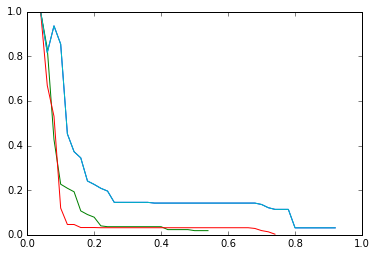

In [34]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB)
plt.plot(tcp_CA.x, tcp_CA)
plt.plot(tcp_BC.x, tcp_BC)
plt.plot(tcp_AC.x, tcp_AC) # same as tcp_AB in MSTIS

We normally look at these on a log scale:

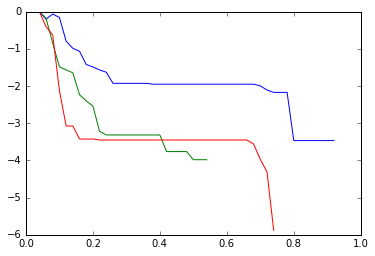

In [35]:
plt.plot(tcp_AB.x, np.log(tcp_AB))
plt.plot(tcp_CA.x, np.log(tcp_CA))
plt.plot(tcp_BC.x, np.log(tcp_BC))

### Flux

Here we also calculate the flux contribution to each transition. The flux is calculated based on 

In [36]:
import pandas as pd
flux_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    flux_matrix.set_value(state_pair[0], state_pair[1], transition._flux)

flux_matrix

,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.0265604,0.0265604
"{x|opB(x) in [0.0, 0.04]}",0.00895255,NaN,0.00895255
"{x|opC(x) in [0.0, 0.04]}",0.108696,0.108696,NaN


### Conditional transition probability

In [37]:
outer_ctp_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.set_value(state_pair[0], state_pair[1], transition.ctp[transition.ensembles[-1]])    

outer_ctp_matrix

,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.371257,0.0319361
"{x|opB(x) in [0.0, 0.04]}",0.974052,NaN,0
"{x|opC(x) in [0.0, 0.04]}",0,0,NaN


In [38]:
ctp_by_interface = pd.DataFrame(index=mstis.transitions)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    for ensemble_i in range(len(transition.ensembles)):
        ctp_by_interface.set_value(
            state_pair, ensemble_i,
            transition.conditional_transition_probability(
                storage.steps,
                transition.ensembles[ensemble_i]
        ))
    
    
ctp_by_interface  

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 61/501=0.121756487026

INFO:openpathsampling.analysis.tis_analysis:CTP: 34/501=0.0678642714571

INFO:openpathsampling.analysis.tis_analysis:CTP: 16/501=0.0319361277445

INFO:openpathsampling.analysis.tis_analysis:CTP: 0/501=0.0

INFO:openpathsampling.analysis.tis_analysis:CTP: 13/501=0.0259481037924

INFO:openpathsampling.analysis.tis_analysis:CTP: 488/501=0.974051896208

INFO:openpathsampling.analysis.tis_analysis:CTP: 22/501=0.0439121756487

INFO:openpathsampling.analysis.tis_analysis:CTP: 24/501=0.0479041916168

INFO:openpathsampling.analysis.tis_analysis:CTP: 186/501=0.37125748503

,0,1,2
"({x|opB(x) in [0.0, 0.04]}, {x|opC(x) in [0.0, 0.04]})",0.000000,0.000000,0.000000
"({x|opC(x) in [0.0, 0.04]}, {x|opA(x) in [0.0, 0.04]})",0.000000,0.000000,0.000000
"({x|opA(x) in [0.0, 0.04]}, {x|opC(x) in [0.0, 0.04]})",0.121756,0.067864,0.031936
"({x|opB(x) in [0.0, 0.04]}, {x|opA(x) in [0.0, 0.04]})",0.000000,0.025948,0.974052
"({x|opA(x) in [0.0, 0.04]}, {x|opB(x) in [0.0, 0.04]})",0.043912,0.047904,0.371257
"({x|opC(x) in [0.0, 0.04]}, {x|opB(x) in [0.0, 0.04]})",0.000000,0.000000,0.000000


## Path ensemble properties

In [39]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of 

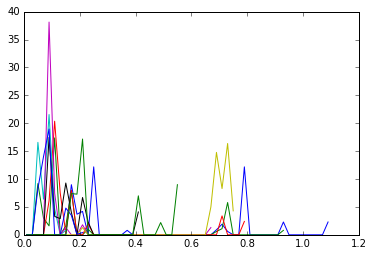

In [40]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [41]:
# add visualization of the sum

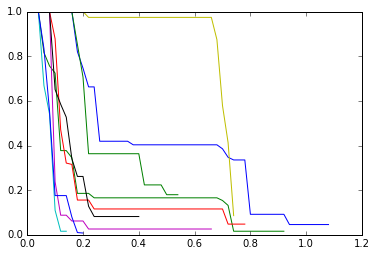

In [42]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative)

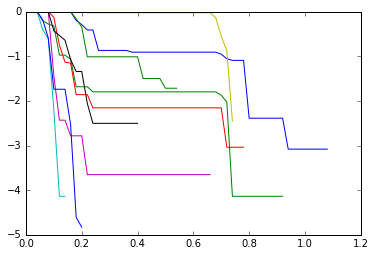

In [43]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

### Path length histograms

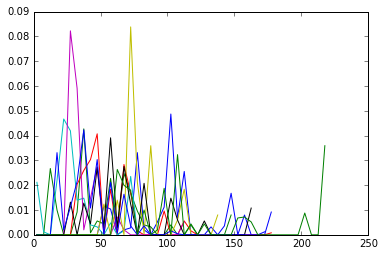

In [44]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

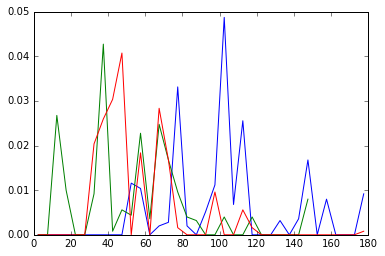

In [45]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [46]:
scheme = storage.schemes[0]

In [47]:
scheme.move_summary(storage.steps)

ms_outer_shooting ran 4.400% (expected 4.98%) of the cycles with acceptance 15/22 (68.18%)
repex ran 20.600% (expected 22.39%) of the cycles with acceptance 29/103 (28.16%)
shooting ran 48.000% (expected 44.78%) of the cycles with acceptance 195/240 (81.25%)
minus ran 2.600% (expected 2.99%) of the cycles with acceptance 11/13 (84.62%)
pathreversal ran 24.400% (expected 24.88%) of the cycles with acceptance 98/122 (80.33%)


In [48]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover I'face 1 ran 5.800% (expected 4.98%) of the cycles with acceptance 23/29 (79.31%)
OneWayShootingMover I'face 0 ran 6.600% (expected 4.98%) of the cycles with acceptance 30/33 (90.91%)
OneWayShootingMover I'face 2 ran 4.800% (expected 4.98%) of the cycles with acceptance 14/24 (58.33%)
OneWayShootingMover I'face 0 ran 4.400% (expected 4.98%) of the cycles with acceptance 20/22 (90.91%)
OneWayShootingMover I'face 2 ran 5.000% (expected 4.98%) of the cycles with acceptance 20/25 (80.00%)
OneWayShootingMover I'face 0 ran 7.200% (expected 4.98%) of the cycles with acceptance 31/36 (86.11%)
OneWayShootingMover I'face 1 ran 4.200% (expected 4.98%) of the cycles with acceptance 18/21 (85.71%)
OneWayShootingMover I'face 2 ran 5.000% (expected 4.98%) of the cycles with acceptance 19/25 (76.00%)
OneWayShootingMover I'face 1 ran 5.000% (expected 4.98%) of the cycles with acceptance 20/25 (80.00%)


In [49]:
scheme.move_summary(storage.steps, 'minus')

Minus ran 1.600% (expected 1.00%) of the cycles with acceptance 8/8 (100.00%)
Minus ran 0.200% (expected 1.00%) of the cycles with acceptance 1/1 (100.00%)
Minus ran 0.800% (expected 1.00%) of the cycles with acceptance 2/4 (50.00%)


In [50]:
scheme.move_summary(storage.steps, 'repex')

ReplicaExchange ran 2.800% (expected 2.49%) of the cycles with acceptance 3/14 (21.43%)
ReplicaExchange ran 2.200% (expected 2.49%) of the cycles with acceptance 4/11 (36.36%)
ReplicaExchange ran 1.600% (expected 2.49%) of the cycles with acceptance 5/8 (62.50%)
ReplicaExchange ran 3.000% (expected 2.49%) of the cycles with acceptance 4/15 (26.67%)
ReplicaExchange ran 2.000% (expected 2.49%) of the cycles with acceptance 6/10 (60.00%)
ReplicaExchange ran 3.000% (expected 2.49%) of the cycles with acceptance 0/15 (0.00%)
ReplicaExchange ran 1.800% (expected 2.49%) of the cycles with acceptance 2/9 (22.22%)
ReplicaExchange ran 0.800% (expected 2.49%) of the cycles with acceptance 1/4 (25.00%)
ReplicaExchange ran 3.400% (expected 2.49%) of the cycles with acceptance 4/17 (23.53%)


In [51]:
scheme.move_summary(storage.steps, 'pathreversal')

PathReversal ran 2.400% (expected 2.49%) of the cycles with acceptance 11/12 (91.67%)
PathReversal ran 2.400% (expected 2.49%) of the cycles with acceptance 12/12 (100.00%)
PathReversal ran 2.000% (expected 2.49%) of the cycles with acceptance 10/10 (100.00%)
PathReversal ran 2.200% (expected 2.49%) of the cycles with acceptance 0/11 (0.00%)
PathReversal ran 2.000% (expected 2.49%) of the cycles with acceptance 10/10 (100.00%)
PathReversal ran 1.600% (expected 2.49%) of the cycles with acceptance 8/8 (100.00%)
PathReversal ran 3.400% (expected 2.49%) of the cycles with acceptance 16/17 (94.12%)
PathReversal ran 1.400% (expected 2.49%) of the cycles with acceptance 6/7 (85.71%)
PathReversal ran 3.400% (expected 2.49%) of the cycles with acceptance 7/17 (41.18%)
PathReversal ran 3.600% (expected 2.49%) of the cycles with acceptance 18/18 (100.00%)


### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [52]:
repx_net = paths.ReplicaNetwork(scheme, storage.steps)

#### Replica exchange mixing matrix

In [53]:
repx_net.mixing_matrix()

,12,6,7,8,9,2,1,0,11,10,3,4,5
12,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.017241,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.034483,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.034483,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.017241,0.000000,0.043103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.043103,0.000000,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.008621,0.000000,0.051724,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051724,0.000000,0.068966,0.000000,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008621,0.000000,0.000000


#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

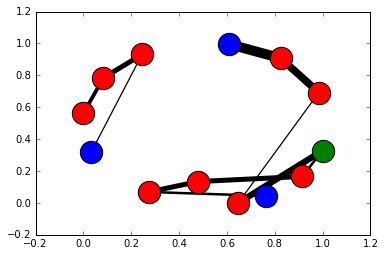

In [54]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [55]:
import openpathsampling.visualize as vis
reload(vis)
from IPython.display import SVG

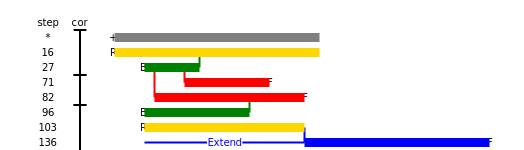

In [56]:
tree = vis.PathTree(
    storage.steps[0:200],
    vis.ReplicaEvolution(replica=2, accepted=False)
)

# print [s.mover for s in tree.samples]

SVG(tree.svg())

In [57]:
decorrelated = tree.generator.decorrelated
print "We have " + str(len(decorrelated)) + " decorrelated trajectories."

We have 3 decorrelated trajectories.


### Visualizing trajectories

In [58]:
from toy_plot_helpers import ToyPlot
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(storage.engines[0].pes)

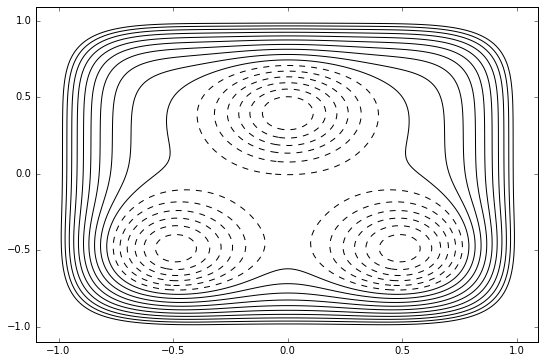

In [59]:
xval = paths.CV_Function("xval", lambda snap : snap.xyz[0][0])
yval = paths.CV_Function("yval", lambda snap : snap.xyz[0][1])
live_vis = paths.LiveVisualization(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
live_vis.background = background.plot()

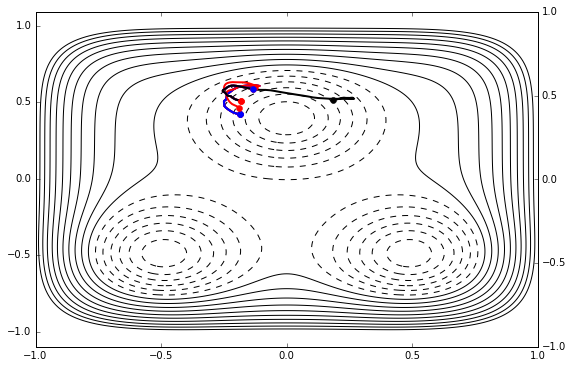

In [60]:
live_vis.draw_samples(list(tree.samples))

## Histogramming data (TODO)

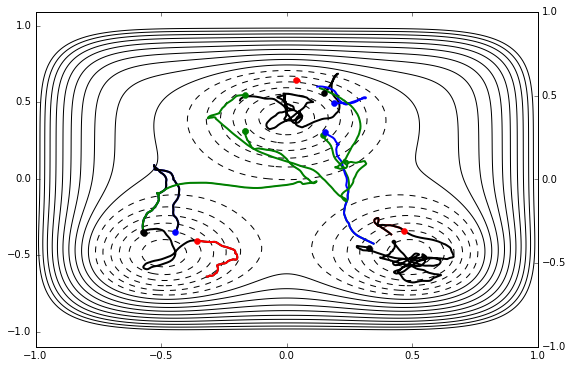

In [57]:
#! skip
# The skip directive tells our test runner not to run this cell
import time
max_step = 10
for step in storage.steps[0:max_step]:
    live_vis.draw_ipynb(step)
    time.sleep(0.1)